# Room Acoustic Measurment

## Background

This is a prototype program that will be able to run testing on your room accoustic. All you need to do is perform a few recordings, those being the following:
1. Recording of an impulse response (WAV of IR is provided below)
2. Recording of a sine sweep (WAV of sweep also provided)

These recordings must be done in a 24-bit, 44.1kHZ, .wav format (Single channel is fine atm). Positionally the microphone should be in the position you listen from at ear position height. To perform test recordings must have minimal background noise. Run your wave files through the "floorNoiseCheck" function before performing any other tasks. This will give you a boolean and a leaking background noise measurment result.

Kinds of measurments

## Import libraries

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
import librosa.display as ld
from IPython.display import Audio 
import scipy.signal as sc
import matplotlib.colors as mcolors
from scipy.optimize import curve_fit

## Dependencies

In [37]:
def linearFit(x,m,b):
    return m*x+b

$L(t) = 10\log{}|$


In [142]:
def schroedersIntegral(signal):


    cumsum = np.zeros(len(signal),dtype=type(signal[0]))
    #signal cumsum
    for i in range(0,len(signal)):
        if i == 0:
            cumsum[i] = signal[i]
        else:
            cumsum[i] = signal[i] + cumsum[i-1]
    
        
    sch = 10.0 * np.log10((cumsum)[::-1] 
                           / np.max(cumsum))
    return sch


In [143]:
def movingAvg(x, k):
    # Reflective padding
    pad_width = k // 2
    x_padded = np.pad(x, pad_width, mode='reflect')
    
    movAvg = []
    # Calculate moving average
    for i in range(len(x)):
        frame = x_padded[i:i+k]
        frameAvg = np.mean(frame)
        movAvg.append(frameAvg)
    
    return np.array(movAvg, dtype='float32')

x = [1, 2, 3, 4, 5, 6, 7, 8]
k = 3

y = movingAvg(x, k)

print("Original length:", len(x))
print("Moving average length:", len(y))

Original length: 8
Moving average length: 8


## Acoustic Measurment

In [146]:
def reverbTimeCalc(signal, fs, window_size, N):
    """
    reverbTimeCalc will determin the reverberation time at RT60,30,20,and 10 for a given impulse respnse.

    Parameters:
    signal: time-series impulse response .wav
    fs: sampling rate 
    window_size: window size for filtering (int)
    N/integration_size: select amount of samples needed to integrate. You dont wnat to integeate the entire power spectrome; only the dip (int)
    
    
    """
    #time array
    t = np.arange(len(signal))/fs

    #Analytical signal removes any phase information
    x_anyl = sc.hilbert(signal)
    print(len(signal),len(x_anyl))
    x_env = np.abs(x_anyl)
    #x_log = 20.0*np.log10(x_env) 
    x_ma = movingAvg(x_env,66)

    #Filter the signal to remove noise
    # ma_filter = np.ones(window_size) / window_size
    # x_ma = np.convolve(x_env, ma_filter, mode='same') 
    
    # x_ma1 = x_ma[:N]

    #sch = 10.0 * np.log10(np.cumsum(x_ma1[::-1]**2)[::-1] / np.max(np.cumsum(x_ma1[::-1]**2))
    N = 7000
    sch = schroedersIntegral(x_ma[:N][::-1]**2)
    
    
    ##ANALYSIS
    popt,pconv = curve_fit(linearFit,t[:N],sch)
    m,b = popt    
    y = m * t + b
    reverbTimeArr = [-60/m,-30/m,-20/m,-10/m]

    plt.figure(figsize = (20,8))
    plt.plot(t,signal,'b',label = "Signal")
    plt.plot(t,x_env,'r',label = "Analytical Signal: no phase info")
    plt.xlim(0,0.04)
    plt.legend()

    plt.figure(figsize = (20,8))
    plt.plot(t,20*np.log10(x_ma),'r',linewidth=3.5,label="Windowed Signal")
    plt.plot(t,20*np.log10(signal),'b',label='Audio Signal')
    plt.plot(t[:N],sch,'xkcd:spearmint',linewidth=3.5,label = "Schroders Integral Curve")
    plt.plot(t[:2*N],y[:2*N],color="tab:orange",ls="dotted",linewidth = 3.5,label = "Curve Fit")
    plt.legend()
    
    return reverbTimeArr



In [ ]:
def freqResponse(signal, ):
    sigFFT = np.fft.rfft(signal)
    pwrSpec = 10*np.log10(sigFFT)
    
    
    
    
    

ValueError: x and y must have same first dimension, but have shapes (904,) and (20,)

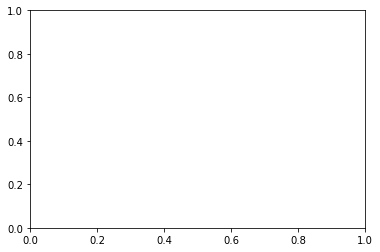

In [70]:
def snrAnyl(signal, fs,  frame_length,  overlap, window_type):
    """
    SNR Analyzer. Will determine the snr levels of your room, ie: ratio between floor noise and direct signal
    
    signal: time-series audio vector
    fs: sampling rate 
    frame_length: number of samples to be processed per frame
    window_type: boxcar, triangle, hann, hamming, etc. 
    overlap: amount of overlapped windows
    """
    if (overlap == 0):
        step = 1;
        numWindows = np.ceil(len(signal)/frame_length);
    else:
        step = int(np.round(overlap*frame_length));
        numWindows = np.ceil(len(signal)/(overlap*frame_length));

    result = np.zeros(int(numWindows))
    k=0
    for i in range(0,len(signal),step):
        st = i
        en = min(frame_length + i, len(signal))
        
        #If end index - start index is less thatn window length - step break
        if (en - st < frame_length - step):
            break
        
        window = sc.windows.get_window(window_type, frame_length);
        #Window/Filter signal 
        windowedSig = sc.convolve(signal[st:en],window)

        segFFT = np.fft.rfft(windowedSig)
        segFFT[0] = 0 ## Remove DC offset
        
        
        result[k] = np.mean(np.abs(segFFT))

        

        k += 1   
    freqs = np.fft.rfftfreq(len(windowedSig), 1 / fs) 
    plt.figure(1)    
    plt.plot(freqs,result)

## Testing

19913 19913


/var/folders/mq/2x3nqx1s3m7_d6yf0m5rddsw0000gn/T/ipykernel_49962/951154340.py:48: RuntimeWarning: divide by zero encountered in log10
  plt.plot(t,20*np.log10(signal),'b',label='Audio Signal')
/var/folders/mq/2x3nqx1s3m7_d6yf0m5rddsw0000gn/T/ipykernel_49962/951154340.py:48: RuntimeWarning: invalid value encountered in log10
  plt.plot(t,20*np.log10(signal),'b',label='Audio Signal')


[0.33804205468710546,
 0.16902102734355273,
 0.11268068489570182,
 0.05634034244785091]

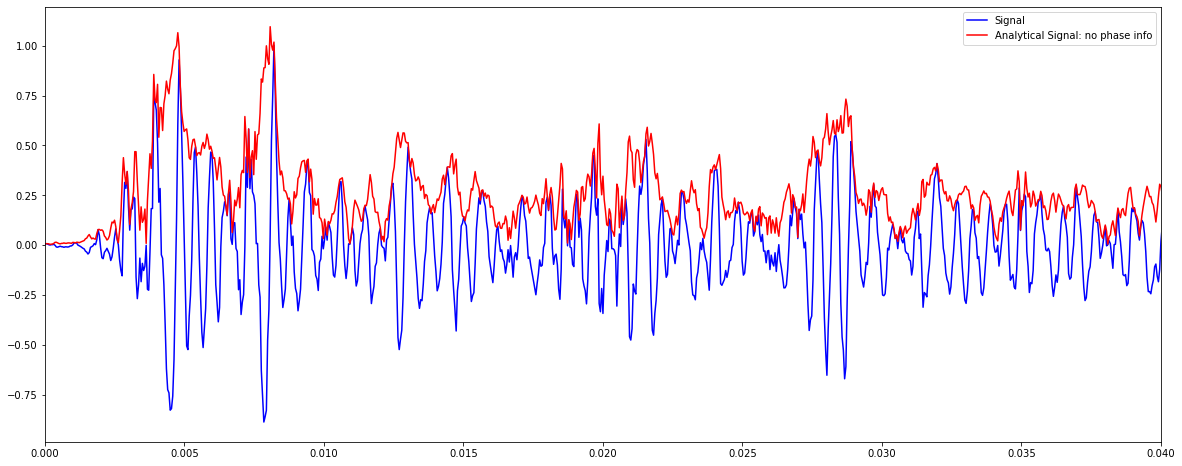

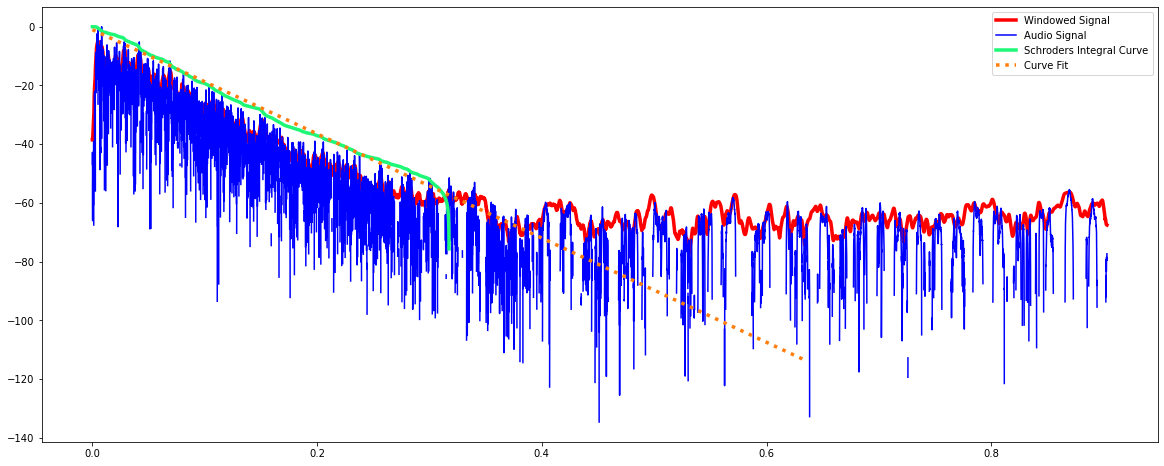

In [147]:
np.set_printoptions(threshold=None, edgeitems=None, linewidth=None, suppress=None)
#Test Signal
y,sr = lr.load("../wavs/bedroom_RIR.wav")

import scipy.io.wavfile as wav

fs, signal = wav.read("../wavs/bedroom_RIR.wav")

signal = signal #/ 32767 # 2**15 - 1

fs = 10000
time = np.arange(0,1,1/fs)
#y = np.sin(2*np.pi*60*time)
noiz = 0.08 * np.random.rand(len(y))

noizy_signal = y + noiz
noizy_signal_fft = np.fft.rfft(noizy_signal)
noizy_signal_fft[0] = 0






#snrAnyl(noiz,sr, 1024, 0.5, "hann")
reverbTimeCalc(y,sr,128,7000)

In [12]:
Audio(y, rate = sr)

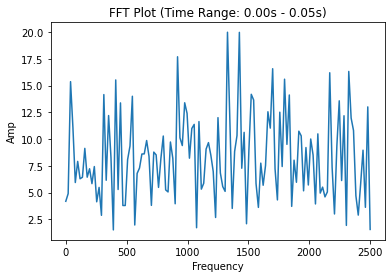

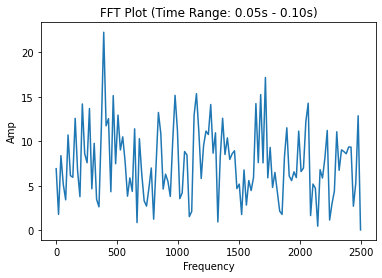

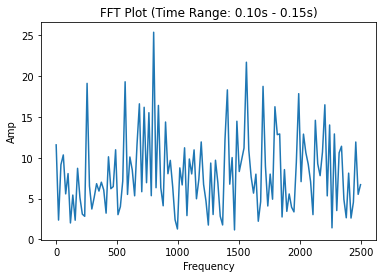

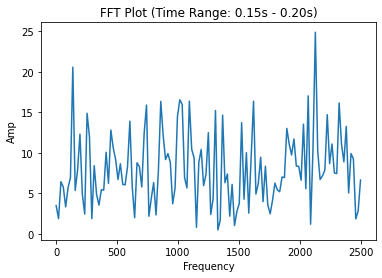

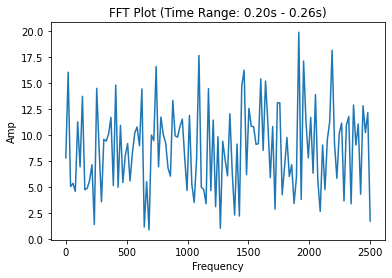

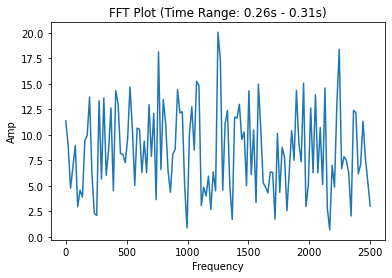

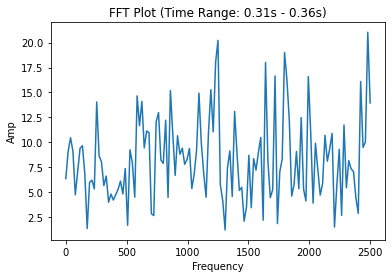

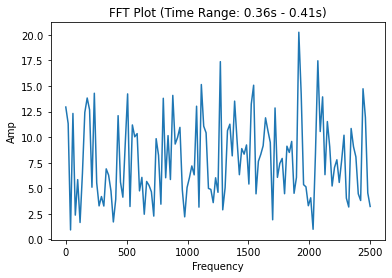

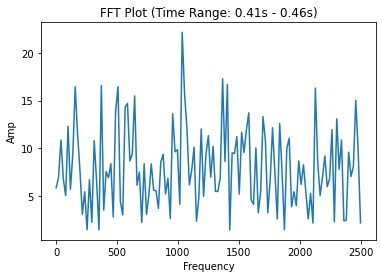

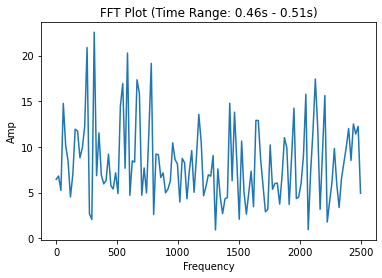

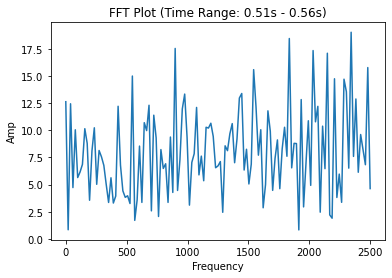

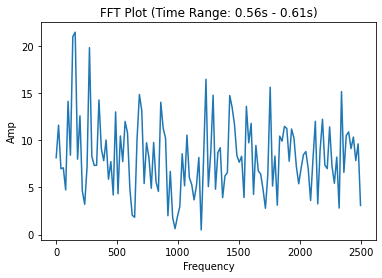

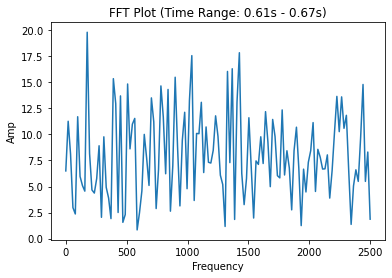

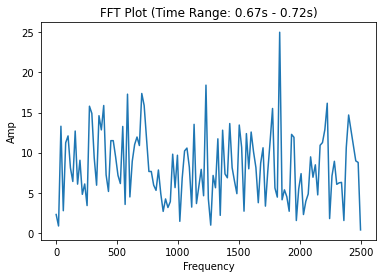

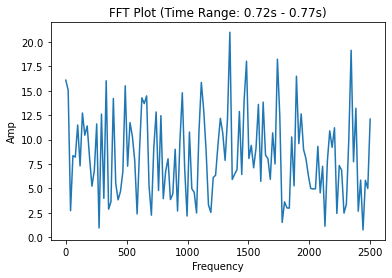

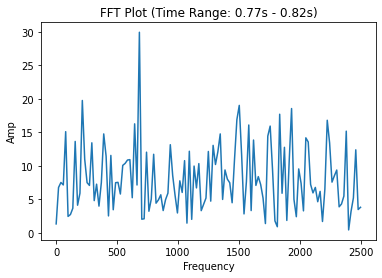

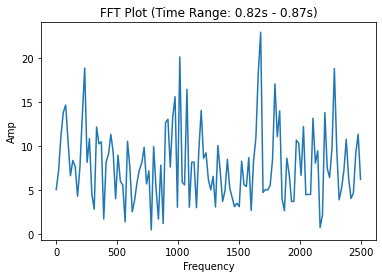

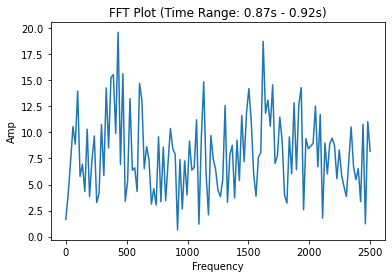

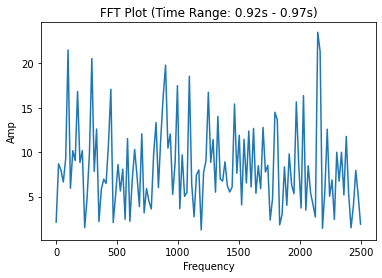

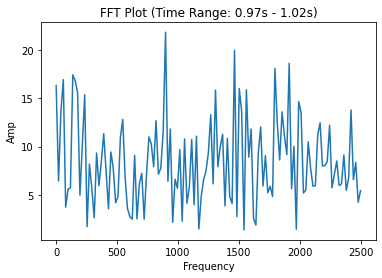

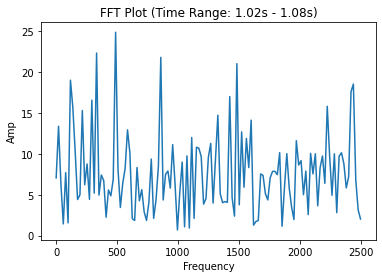

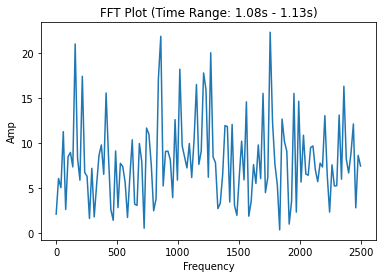

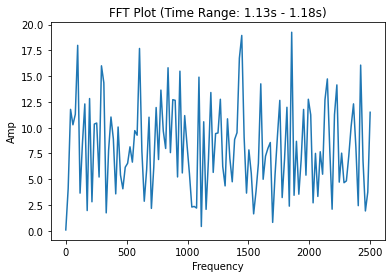

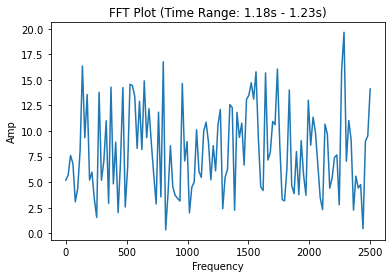

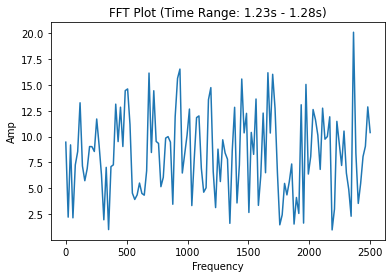

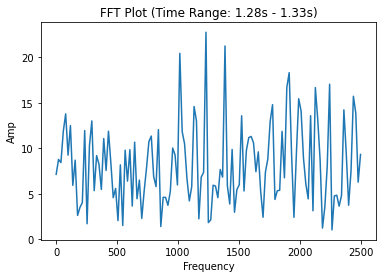

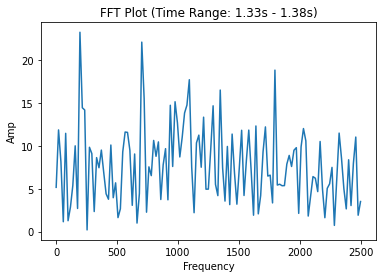

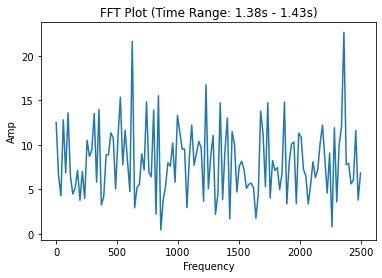

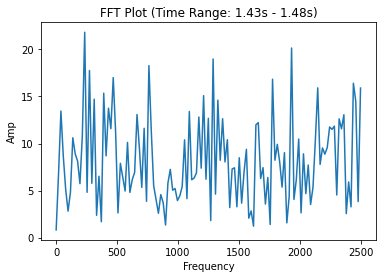

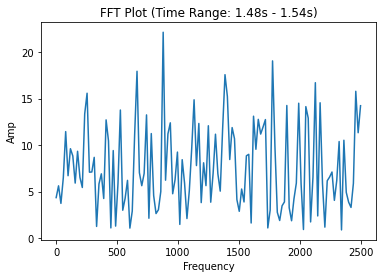

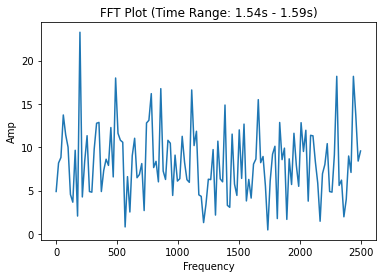

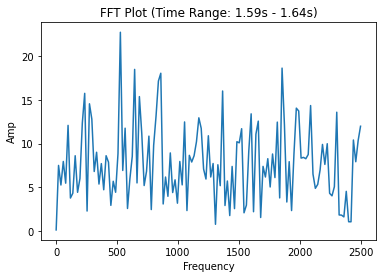

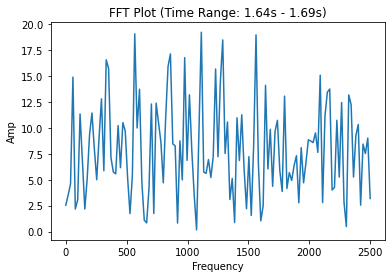

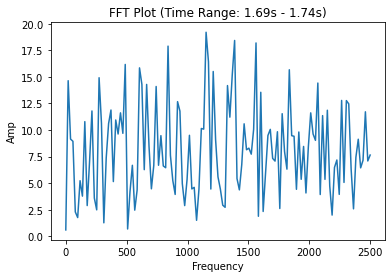

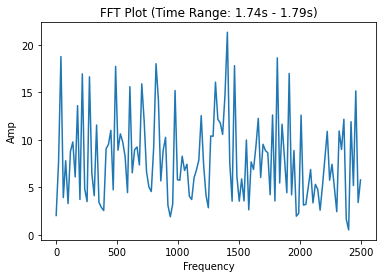

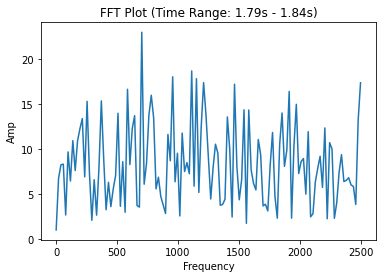

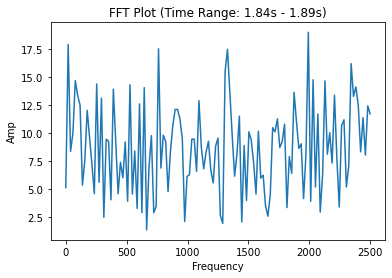

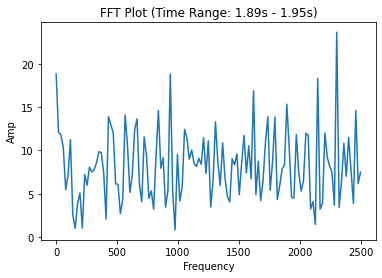

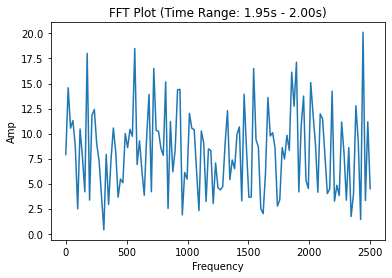

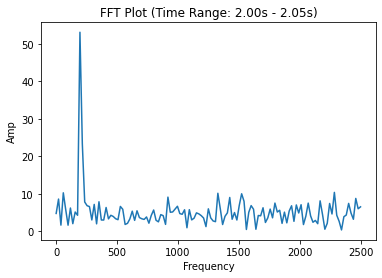

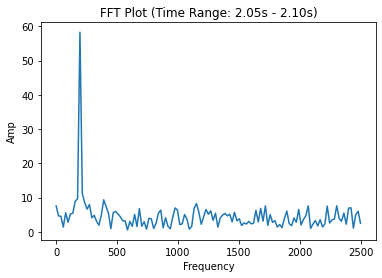

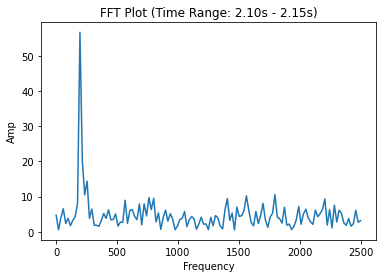

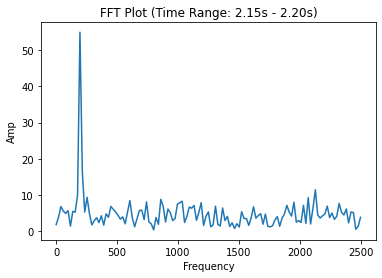

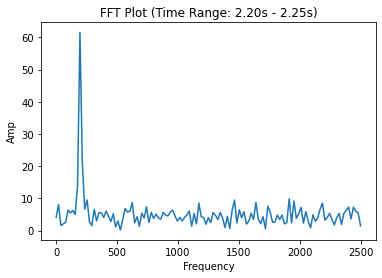

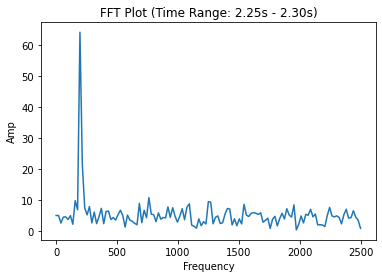

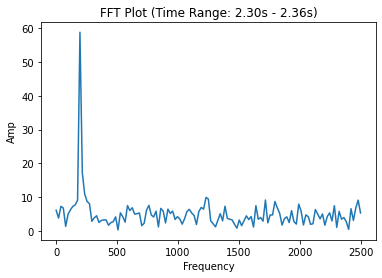

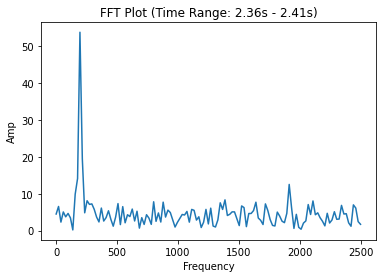

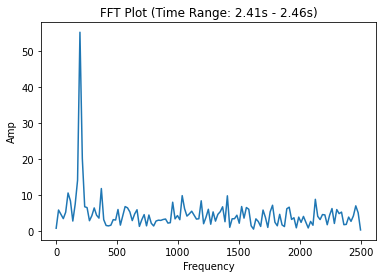

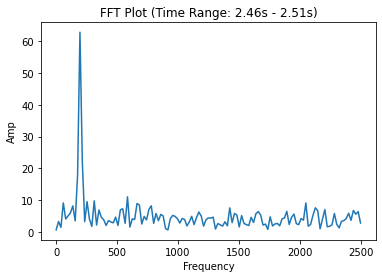

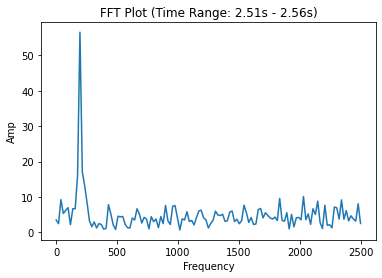

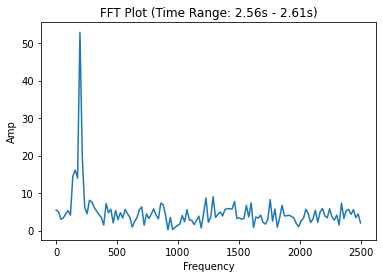

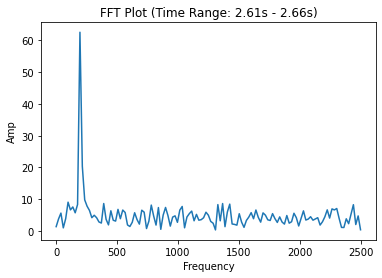

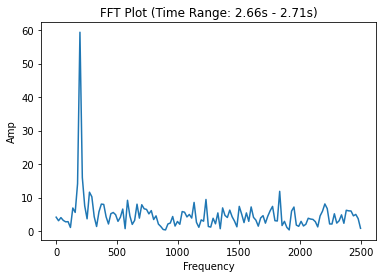

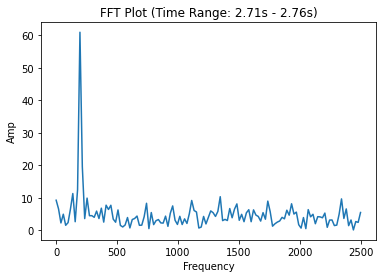

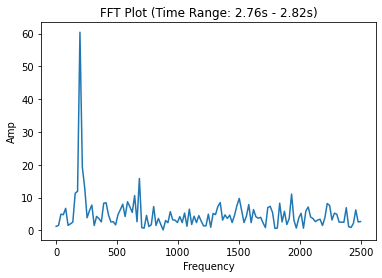

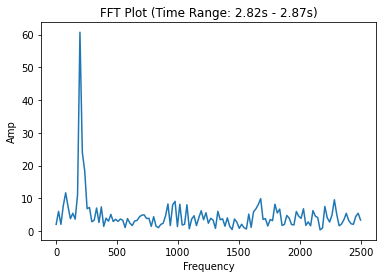

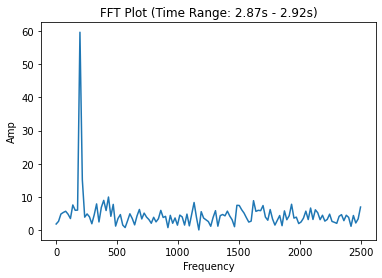

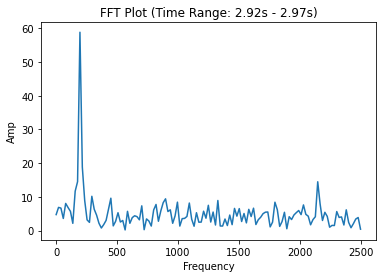

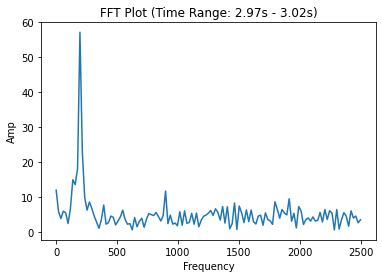

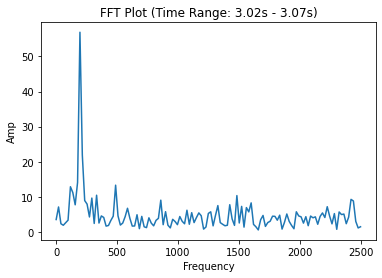

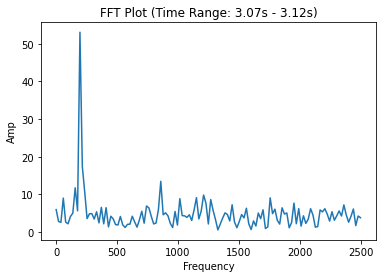

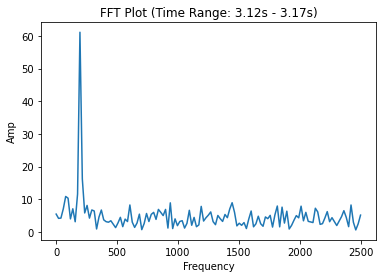

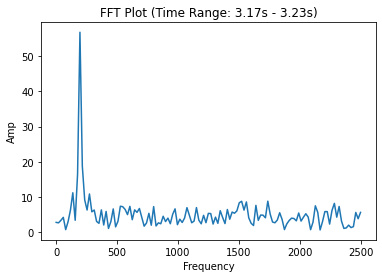

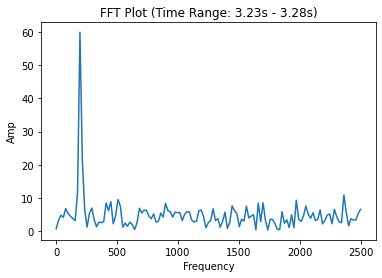

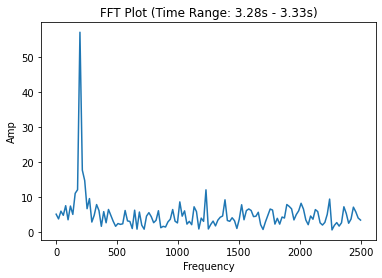

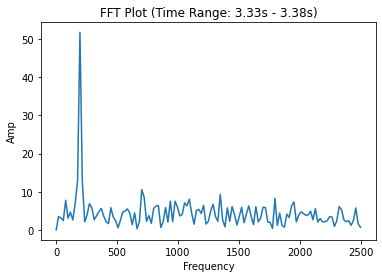

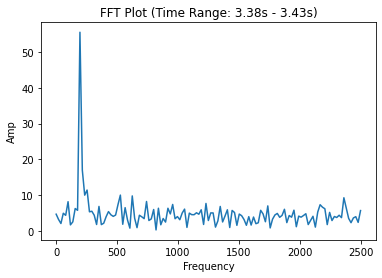

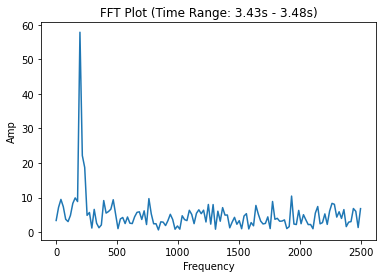

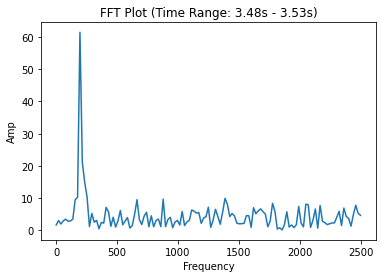

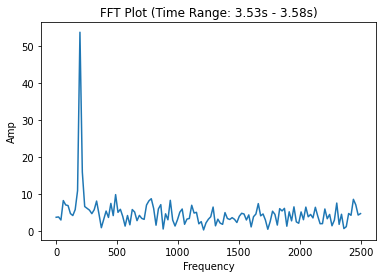

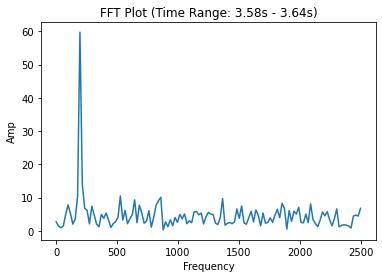

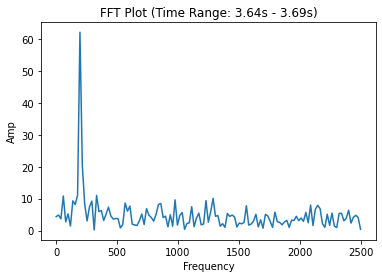

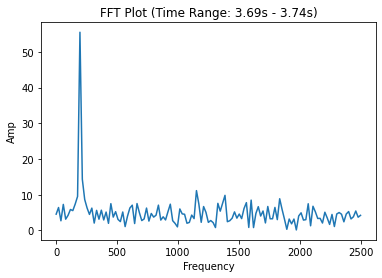

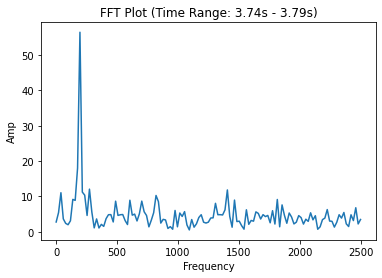

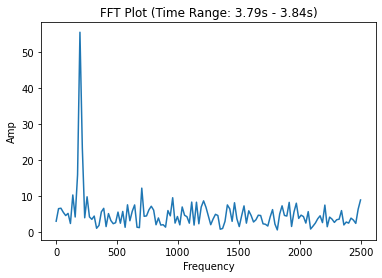

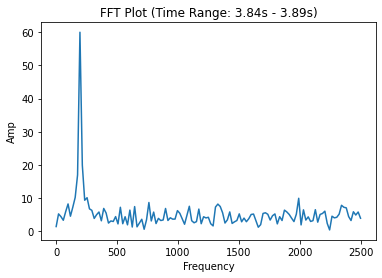

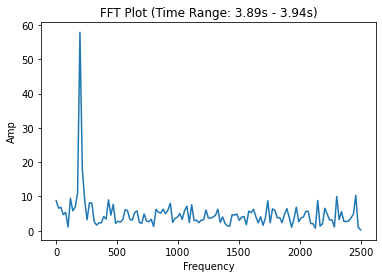

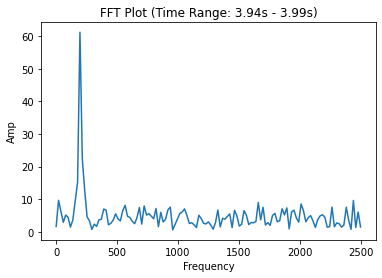

ValueError: x and y must have same first dimension, but have shapes (129,) and (17,)

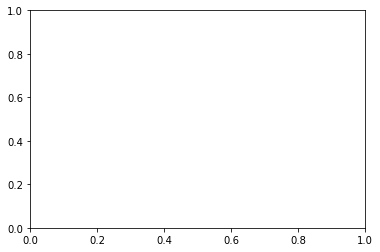

In [13]:
f = 200
sr = 5000
t = np.arange(0,2,1/sr)

noiz = 2*np.random.rand(len(t)) -1 
x= np.sin(2*np.pi*f*t)

signal = np.append(noiz, (noiz+x)*1/2)

window = 256

for i in range(0,len(signal),window):
    st = i
    en = i+window

    signalFrm = signal[st:en]

    fft = np.fft.rfft(signalFrm)
    freq = np.fft.rfftfreq(window, 1/sr)
    plt.plot(freq,np.abs(fft))
    plt.xlabel("Frequency")
    plt.ylabel("Amp")

    startTime = st / sr
    endTime = en /sr
    plt.title(f"FFT Plot (Time Range: {startTime:.2f}s - {endTime:.2f}s)") 
    plt.show()

